TODO:

- Figure showing out of distribution generalisation somehow? Much smaller digits still go to correct protos?
- Retrain Dsprites dataset but with:
  - Hearts only one angle
  - Hearts only on LHS, Squares only TOP, ellipses taking all space?
- Try measure/compare mutual info between z and η? What to compare to? Randomly initialised models? Different components of VAEs Z?
- Figure out second lower bound for InvVAE
- Remove rot = 0 from MNIST VAE plot

In [1]:
%load_ext autoreload
%autoreload 2

from itertools import product
from pathlib import Path

import flax
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
from absl import logging

from clu import deterministic_data

from experiments.utils import load_checkpoint
from src.models.transformation_generative_model import (
    TransformationGenerativeNet,
    create_transformation_generative_state,
)
from src.models.transformation_inference_model import (
    TransformationInferenceNet,
    create_transformation_inference_state,
)
from src.utils.proto_plots import make_get_prototype_fn
from src.utils.plotting import plot_img_array, put_in_grid
from src.utils.input import get_data
from experiments.configs.inf_best import get_config as get_inf_config
from experiments.configs.gen_best import get_config as get_gen_config

flax.config.update("flax_use_orbax_checkpointing", True)
logging.set_verbosity(logging.INFO)
plt.rcParams["savefig.facecolor"] = "white"

/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [41]:
import matplotlib
import matplotlib.gridspec as gridspec

text_width = 6.75  # in  --> Confirmed with template explanation
line_width = 3.25 # in
dpi = 300

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9  #  figure titles

matplotlib.rc("font", size=fs)  # controls default text sizes
matplotlib.rc("axes", titlesize=fs)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=fs)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=fs_m1)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=fs_m1)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=7)  # legend fontsize
# matplotlib.rc(
#     "figure", titlesize=fs_p1, dpi=dpi, autolayout=True
# )  # fontsize of the figure
matplotlib.rc("lines", linewidth=1, markersize=3)
# matplotlib.rc("savefig", dpi=1200, bbox="tight")
matplotlib.rc("grid", alpha=0.3)
matplotlib.rc("axes", grid=True)

matplotlib.rc("font", **{"family": "serif", "serif": ["Times New Roman"]})
matplotlib.rc("text", usetex=True)
# add amsmath to the latex preamble
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

## dSprites

In [3]:
inf_config = get_inf_config("aug_dsprites,0")

rng = random.PRNGKey(inf_config.seed)
data_rng, init_rng = random.split(rng)

train_ds, val_ds, _ = get_data(inf_config, data_rng)
input_shape = train_ds.element_spec["image"].shape[2:]

inf_model = TransformationInferenceNet(
    bounds=inf_config.get("augment_bounds", None),
    offset=inf_config.get("augment_offset", None),
    **inf_config.model.to_dict(),
)

inf_state = create_transformation_inference_state(
    inf_model, inf_config, init_rng, input_shape
)

inf_model_checkpoint_path = Path("../best_ckpts/learning-invariances-models/inf_best_ckpt_aug_dsprites_0")

inf_final_state, inf_config_loaded = load_checkpoint(
    inf_model_checkpoint_path, inf_state, inf_config
)

I0000 00:00:1706090713.979856  518961 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO:absl:Features before preprocessing: {'image': 'uint8[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=1, clip_values=False, key='image', key_result=None):
{'image': 'float32[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op MoveKey(key='label_shape', key_result='label'):
{'image': 'float32[64, 64, 1]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]', 'label': 'int64[]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{

In [4]:
gen_config = get_gen_config("aug_dsprites,0")

rng = random.PRNGKey(gen_config.seed)
data_rng, init_rng = random.split(rng)

train_ds, val_ds, _ = get_data(gen_config, data_rng)
input_shape = train_ds.element_spec["image"].shape[2:]

gen_model = TransformationGenerativeNet(
    bounds=gen_config.get("augment_bounds", None),
    offset=gen_config.get("augment_offset", None),
    **gen_config.model.to_dict(),
)

gen_state = create_transformation_generative_state(
    gen_model, gen_config, init_rng, input_shape
)

gen_model_checkpoint_path = Path("../best_ckpts/learning-invariances-models/gen_best_ckpt_aug_dsprites_1")

gen_final_state, gen_config_loaded = load_checkpoint(
    gen_model_checkpoint_path, gen_state, gen_config
)

INFO:absl:Features before preprocessing: {'image': 'uint8[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=1, clip_values=False, key='image', key_result=None):
{'image': 'float32[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op MoveKey(key='label_shape', key_result='label'):
{'image': 'float32[64, 64, 1]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]', 'label': 'int64[]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{'image': 'float32[64, 64, 1]', 'label': 'int64[]'}
INFO:absl:Features after preprocessing:

In [5]:
# function to take a batch of images and labels, and return n examples of each label
def get_examples_of_each_label(images, labels, n=1):
    # get the unique labels
    unique_labels = np.unique(labels)
    # initialize a list to store the images
    images_list = []
    # loop over the unique labels
    for label in unique_labels:
        for i in range(n):
            # get the indices of the images with the current label
            indices = np.where(labels == label)[0]
            # get the first image with the current label
            image = images[indices[i]]
            # append the image to the list, converted to numpy array
            images_list.append(image.numpy())
    
    return images_list

In [6]:
get_prototype = make_get_prototype_fn(
    inf_model,
    inf_final_state,
    rng,
    inf_model.transform,
    inf_config.get("transform_kwargs", None),
)

In [7]:
def resample(x, rng):
    q_H_given_x = inf_model.apply({"params": inf_final_state.params}, x, train=False)
    η = q_H_given_x.sample(seed=rng)
    η_transform = inf_model.transform(η)
    η_transform_inv = η_transform.inverse()
    x_hat = η_transform_inv.apply(x, **(inf_config.transform_kwargs or {}))

    p_H_given_x_hat = gen_model.apply({"params": gen_final_state.params}, x_hat, train=False)
    η_new = p_H_given_x_hat.sample(seed=rng)
    η_new_transform = inf_model.transform(η_new)

    new_x = η_transform_inv.compose(η_new_transform).apply(
        x, **(inf_config.transform_kwargs or {})
    )

    return new_x

In [8]:
rng = random.PRNGKey(888)
data_rng, init_rng = random.split(rng)

train_ds, val_ds, _ = get_data(gen_config, data_rng)

INFO:absl:Features before preprocessing: {'image': 'uint8[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=1, clip_values=False, key='image', key_result=None):
{'image': 'float32[64, 64, 1]', 'label_shape': 'int64[]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op MoveKey(key='label_shape', key_result='label'):
{'image': 'float32[64, 64, 1]', 'value_scale': 'float64[]', 'value_orientation': 'float64[]', 'value_x_position': 'float64[]', 'value_y_position': 'float64[]', 'rng': 'int32[2]', 'label': 'int64[]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{'image': 'float32[64, 64, 1]', 'label': 'int64[]'}
INFO:absl:Features after preprocessing:

In [9]:
@jax.jit
def get_prototype(x, rng):
    p_η = inf_model.apply({"params": inf_final_state.params}, x, train=False)
    η = p_η.sample(seed=rng)
    η_transform = inf_model.transform(η)
    η_transform_inv = η_transform.inverse()
    xhat = η_transform_inv.apply(x, **(inf_config.transform_kwargs or {}))
    return xhat, η

In [10]:
batch = next(iter(val_ds))
labels = batch['label'][0]
# for each label, give the indices of the first 16 images with that label
indices = [list(np.where(labels == i)[0][:16]) for i in range(3)]
indices

[[2, 3, 5, 7, 9, 10, 12, 13, 14, 15, 17, 18, 21, 22, 27, 29],
 [0, 4, 6, 8, 24, 25, 28, 30, 40, 45, 47, 52, 57, 59, 64, 65],
 [1, 11, 16, 19, 20, 23, 26, 31, 32, 33, 35, 36, 38, 39, 42, 43]]

In [11]:
# idxs:
# s - 0, 1, 2, 6, 7, 8, 9
# c - 0, 1, 2, 4, 5, 7, 8, 
# h - 0, 1, 2, 3, 4, 14, 46

In [12]:
batch = next(iter(val_ds))
idxs = [
    2, 3, 5, 12, 13, 14, 15,
    0, 4, 6, 24, 25, 30, 40,
    1, 19, 11, 16, 23, 42, 46
    # 44, 46, 48, 49, 50, 55, 56, 61, 68, 69, 83, 85, 88, 90, 95, 104
]
val_images = list(batch['image'][0].numpy()[idxs])
# val_images = get_examples_of_each_label(batch['image'][0], batch['label'][0], 2)

fold_ins = [
    0, 1, 0, 2, 0, 0, 0,
    1, 1, 1, 1, 1, 1, 1,
    0, 2, 0, 0, 2, 2, 2,
]

# get the prototypes for the images
prototypes = [get_prototype(image, random.fold_in(rng, i))[0] for i, image in zip(fold_ins, val_images)]

# get the resampled images
resampled_images = [resample(image, random.fold_in(rng, i)) for i, image in zip(fold_ins, val_images)]

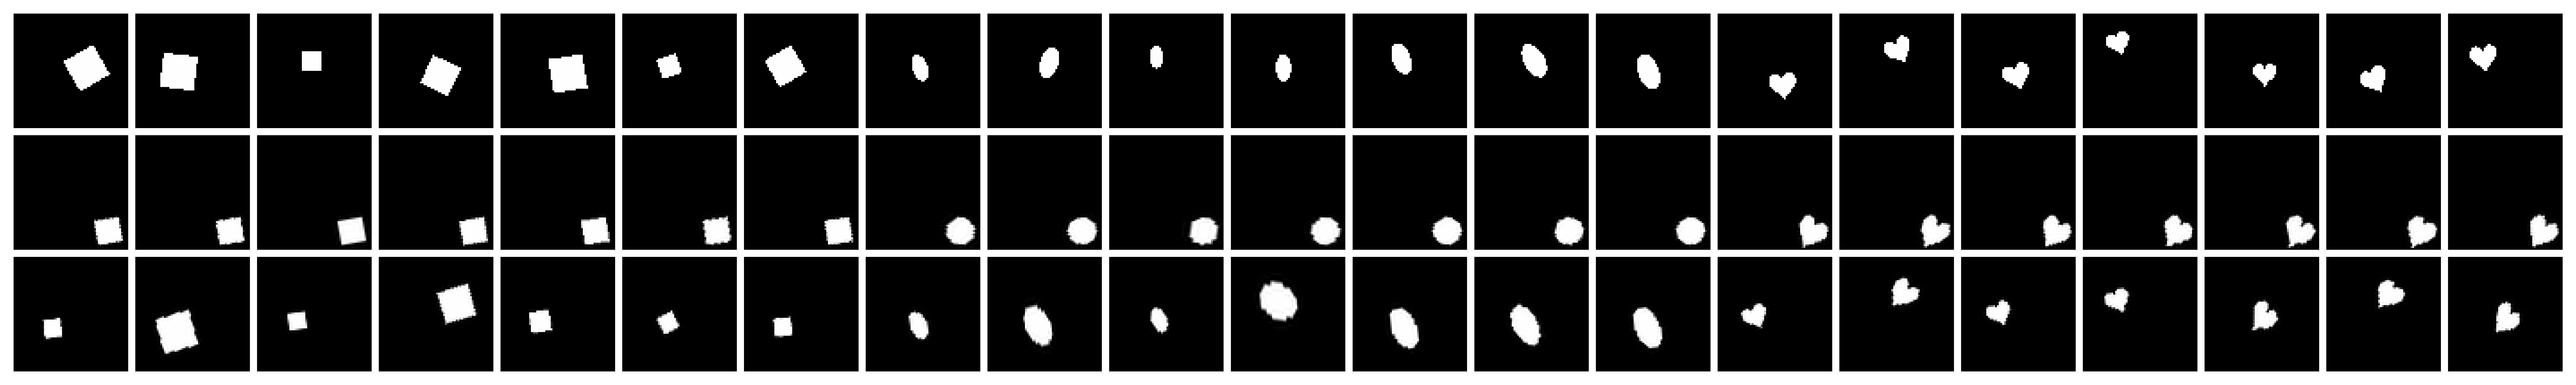

In [13]:
array = np.array(val_images + prototypes + resampled_images)

grid, xmaps, ymaps = put_in_grid(array, len(val_images), padding=4, pad_value=255, return_maps=True)

fig = plt.figure(figsize=(2 * xmaps, 2 * ymaps), dpi=dpi)
plt.imshow(grid)
plt.axis("off")
plt.tight_layout()

plt.savefig("dsprites_proto_resample.pdf", pad_inches=0.0, bbox_inches='tight', dpi=600)

plt.show()

In [14]:
hearts_batch = jax.tree_map(lambda x: x[batch["label"] == 0], batch)
ellipses_batch = jax.tree_map(lambda x: x[batch["label"] == 1], batch)
squares_batch = jax.tree_map(lambda x: x[batch["label"] == 2], batch)

# take the first 16 images from each batch
hearts_batch = jax.tree_map(lambda x: x[:16], hearts_batch)
ellipses_batch = jax.tree_map(lambda x: x[:16], ellipses_batch)
squares_batch = jax.tree_map(lambda x: x[:16], squares_batch)

resampled_hearts = [resample(image.numpy(), random.fold_in(rng, i)) for i, image in enumerate(hearts_batch['image'])]
resampled_ellipses = [resample(image.numpy(), random.fold_in(rng, i)) for i, image in enumerate(ellipses_batch['image'])]
resampled_squares = [resample(image.numpy(), random.fold_in(rng, i)) for i, image in enumerate(squares_batch['image'])]

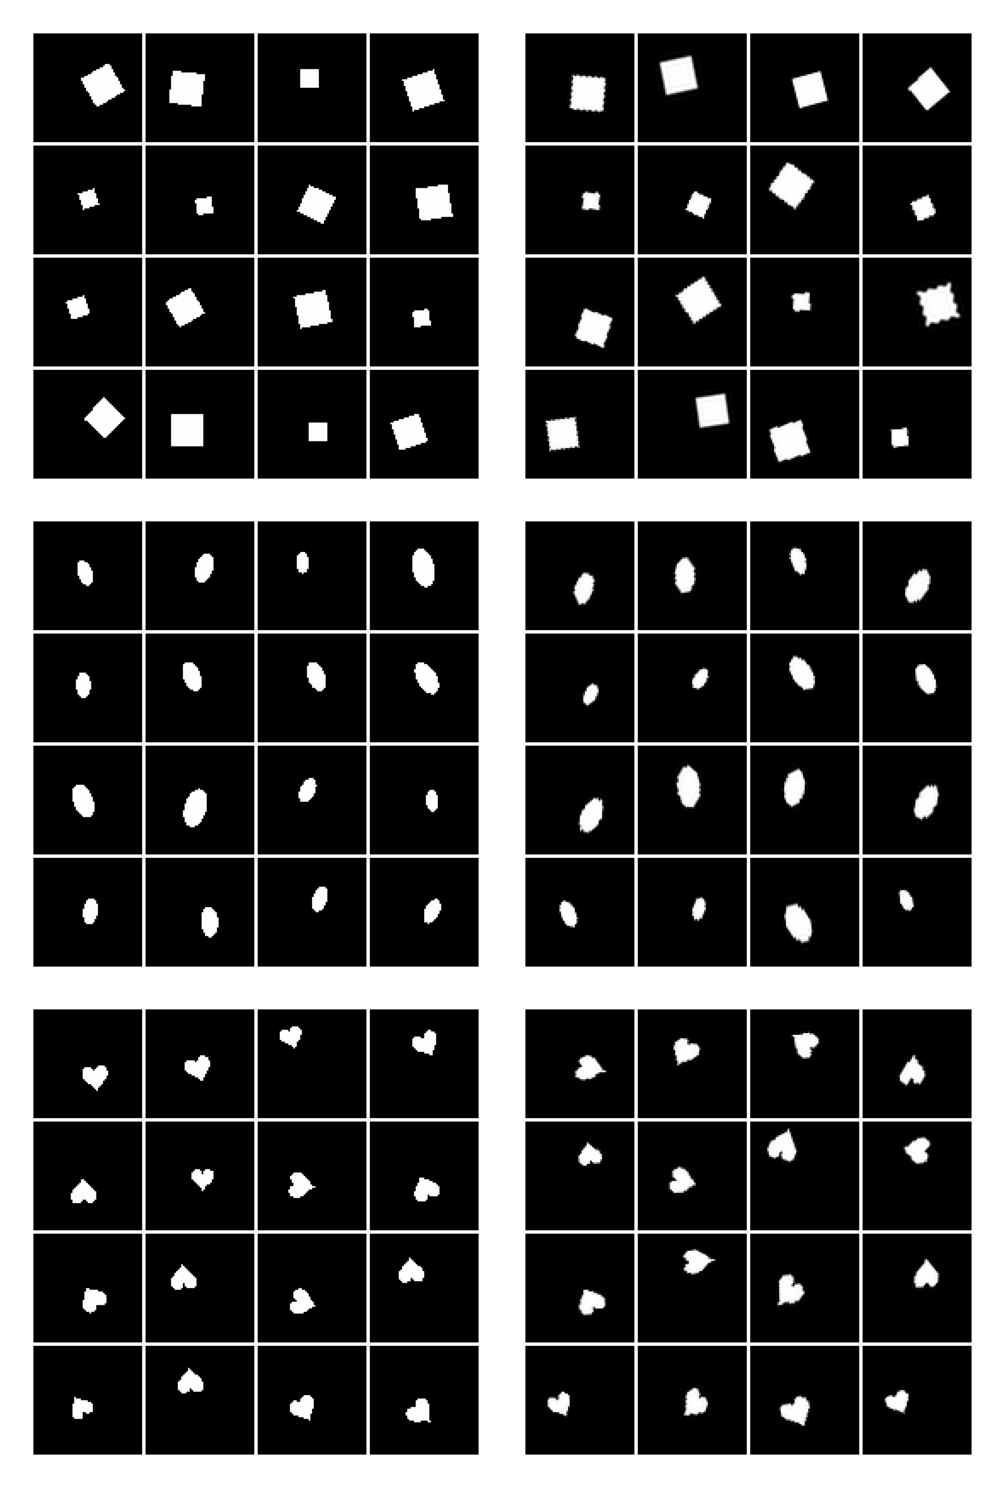

In [15]:
# make a matplotlib figure with 3 rows and 2 columns
fig, ax = plt.subplots(3, 2, figsize=(3.5, 5.), dpi=300)

# plot the original images in the first column
ax[0, 0].imshow(put_in_grid(hearts_batch['image'].numpy(), ncol=4, pad_value=255, padding=2))
ax[1, 0].imshow(put_in_grid(ellipses_batch['image'].numpy(), ncol=4, pad_value=255, padding=2))
ax[2, 0].imshow(put_in_grid(squares_batch['image'].numpy(), ncol=4, pad_value=255, padding=2))

# plot the resampled images in the second column
ax[0, 1].imshow(put_in_grid(list(reversed(resampled_hearts)), ncol=4, pad_value=255, padding=2))
ax[1, 1].imshow(put_in_grid(list(reversed(resampled_ellipses)), ncol=4, pad_value=255, padding=2))
ax[2, 1].imshow(put_in_grid(list(reversed(resampled_squares)), ncol=4, pad_value=255, padding=2))

# remove the axes
for i in range(3):
    for j in range(2):
        ax[i, j].axis('off')

# make the figure tight
fig.tight_layout()

## MNIST Affine

In [16]:
def get_proto_and_resample_fns(inf_config, gen_config, inf_model_checkpoint_path, gen_model_checkpoint_path):
    rng = random.PRNGKey(inf_config.seed)
    data_rng, init_rng = random.split(rng)

    train_ds, _, _ = get_data(inf_config, data_rng)
    input_shape = train_ds.element_spec["image"].shape[2:]

    inf_model = TransformationInferenceNet(
        bounds=inf_config.get("augment_bounds", None),
        offset=inf_config.get("augment_offset", None),
        **inf_config.model.to_dict(),
    )

    inf_state = create_transformation_inference_state(
        inf_model, inf_config, init_rng, input_shape
    )

    inf_final_state, _ = load_checkpoint(
        inf_model_checkpoint_path, inf_state, inf_config
    )

    gen_model = TransformationGenerativeNet(
        bounds=gen_config.get("augment_bounds", None),
        offset=gen_config.get("augment_offset", None),
        **gen_config.model.to_dict(),
    )

    gen_state = create_transformation_generative_state(
        gen_model, gen_config, init_rng, input_shape
    )

    gen_final_state, _ = load_checkpoint(
        gen_model_checkpoint_path, gen_state, gen_config
    )

    @jax.jit
    def get_prototype(x, rng):
        p_η = inf_model.apply({"params": inf_final_state.params}, x, train=False)
        η = p_η.sample(seed=rng)
        η_transform = inf_model.transform(η)
        η_transform_inv = η_transform.inverse()
        xhat = η_transform_inv.apply(x, **(inf_config.transform_kwargs or {}))
        return xhat, η

    @jax.jit
    def resample(x, rng):
        q_H_given_x = inf_model.apply({"params": inf_final_state.params}, x, train=False)
        η = q_H_given_x.sample(seed=rng)
        η_transform = inf_model.transform(η)
        η_transform_inv = η_transform.inverse()
        x_hat = η_transform_inv.apply(x, **(inf_config.transform_kwargs or {}))

        p_H_given_x_hat = gen_model.apply({"params": gen_final_state.params}, x_hat, train=False)
        η_new, η_prob = p_H_given_x_hat.sample_and_log_prob(seed=rng)
        η_new_transform = inf_model.transform(η_new)

        new_x = η_transform_inv.compose(η_new_transform).apply(
            x, **(inf_config.transform_kwargs or {})
        )

        return new_x, η_new, η_prob
    
    return get_prototype, resample

In [17]:
inf_config = get_inf_config("MNIST,1,15,50000")
gen_config = get_gen_config("MNIST,1,15,50000")

inf_path = Path("../best_ckpts/learning-invariances-models/inf_best_ckpt_MNIST_1_15_50000")
gen_path = Path("../best_ckpts/learning-invariances-models/gen_best_ckpt_MNIST_1_15_50000")

In [18]:
get_prototype, resample = get_proto_and_resample_fns(inf_config, gen_config, inf_path, gen_path)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-0.2617993877991494, θ_max=0.2617993877991494, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'la

In [19]:
rng = random.PRNGKey(inf_config.seed)
data_rng, init_rng = random.split(rng)

train_ds, val_ds, _ = get_data(gen_config, data_rng)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-0.2617993877991494, θ_max=0.2617993877991494, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'la

In [20]:
labels = batch['label'][0]
# for each label, give the indices of the first 16 images with that label
indices = [list(np.where(labels == i)[0][:16]) for i in range(10)]
indices

[[2, 3, 5, 7, 9, 10, 12, 13, 14, 15, 17, 18, 21, 22, 27, 29],
 [0, 4, 6, 8, 24, 25, 28, 30, 40, 45, 47, 52, 57, 59, 64, 65],
 [1, 11, 16, 19, 20, 23, 26, 31, 32, 33, 35, 36, 38, 39, 42, 43],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [21]:
# Indices:
# 0 - 1, 4, 13
# 1 - 1, 8
# 2 - 4, 5
# 3 - 0, 8, 6
# 4 - 0, 2, 4
# 5 - 0, 2, 11
# 6 - 0, 1, 12
# 7 - 0, 1, 10 (2)
# 8 - 0, 8, 14
# 9 - 1, 4, 10

2024-01-24 10:36:41.241287: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


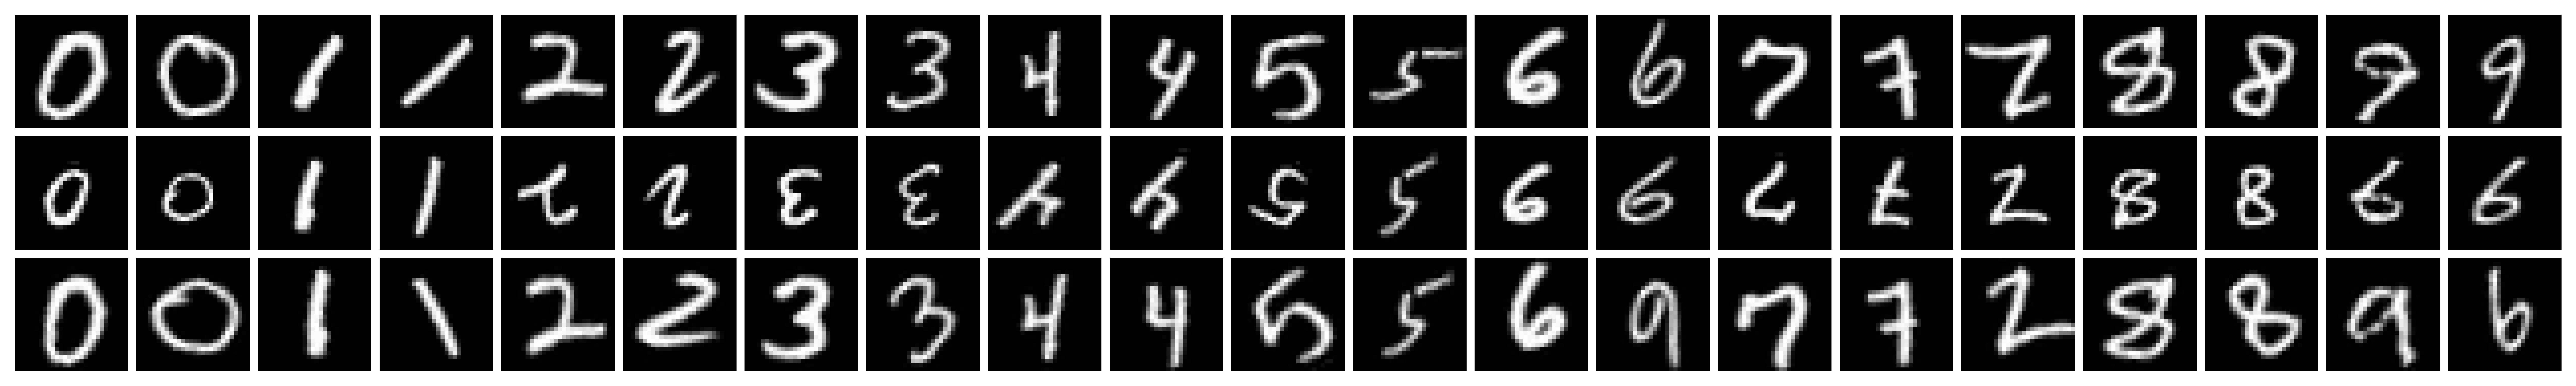

In [48]:
# get three validation images, one for each class
batch = next(iter(val_ds))
idxs = [
    20, 43, #216, 
    5, 65, #1,
    78, 84, #101,
    14, 113, #58, 
    0, 25, #34,
    52, 68, #183,
    9, 10, #144,
    3, 7, 90,
    4, 116, #166,
    18, 27, #100
]
val_images = list(batch['image'][0].numpy()[idxs])
# val_images = get_examples_of_each_label(batch['image'][0], batch['label'][0], 2)

fold_ins = [0, 1, 0, 3, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3]

# get the prototypes for the images
prototypes = [get_prototype(image, random.fold_in(rng, i))[0] for i, image in zip(fold_ins, val_images)]

# get the resampled images
resampled_images = [resample(image, random.fold_in(rng, i))[0] for i, image in zip(fold_ins, val_images)]

array = np.array(val_images + prototypes + resampled_images)
# fig = plot_img_array(array, ncol=len(val_images), pad_value=255, padding=2, dpi=300)

grid, xmaps, ymaps = put_in_grid(array, len(val_images), padding=2, pad_value=255, return_maps=True)

fig = plt.figure(figsize=(2 * xmaps, 2 * ymaps), dpi=dpi)
plt.imshow(grid)
plt.axis("off")
plt.tight_layout()

plt.savefig("mnist_proto_resample.pdf", pad_inches=0.0, bbox_inches='tight', dpi=600)

plt.show()


<Figure size 640x480 with 0 Axes>

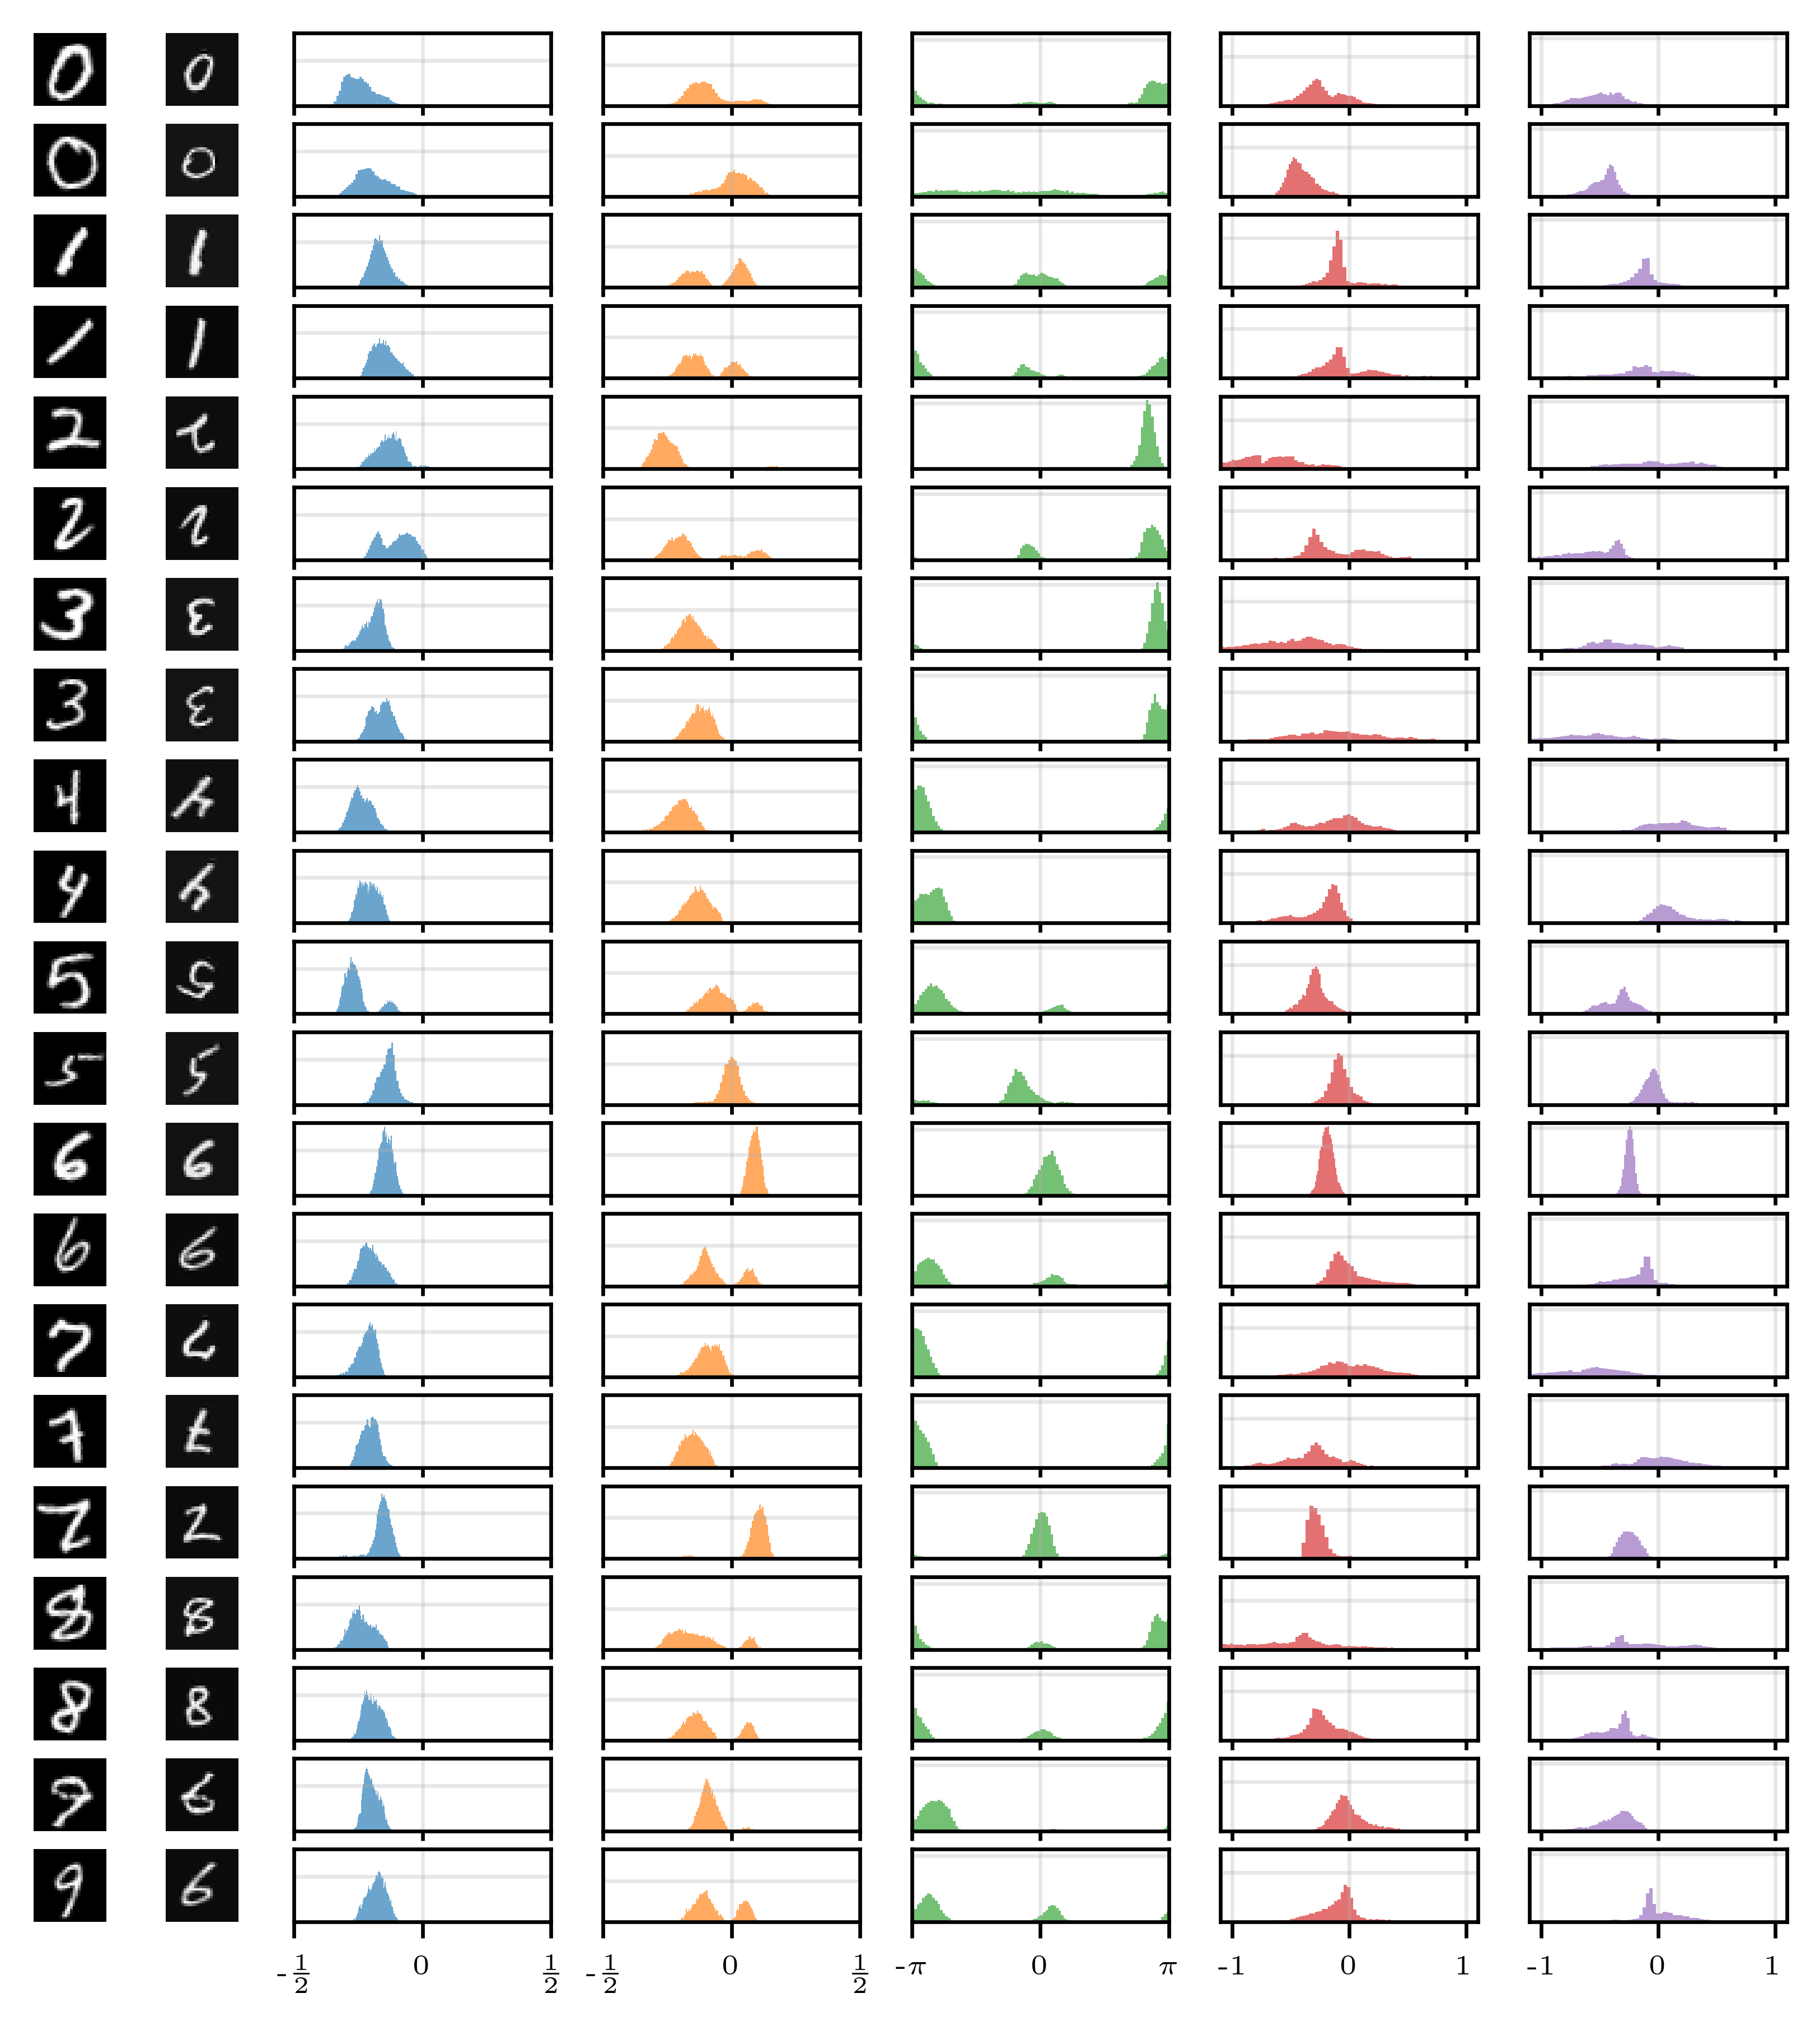

In [49]:
plt.clf()

# idxs = [
#     43,
#     65,
#     84,
#     18,
#     27,
# ]
val_images = list(batch['image'][0].numpy()[idxs])

golden_ratio = (5**.5 - 1) / 2
fig, axs = plt.subplots(nrows=len(idxs), ncols=7, dpi=600, constrained_layout=False, sharey='col',
                           figsize=(text_width, text_width * golden_ratio * len(idxs) / 12),
                           gridspec_kw={"width_ratios": [1.25, 1.25, 4, 4, 4, 4, 4]}
                           ) 

for row, (image, ax) in enumerate(zip(val_images, axs)):
    proto = get_prototype(image, rng)[0]
    _, ηs, log_probs = jax.vmap(resample, in_axes=(None, 0))(image, jax.vmap(random.fold_in, in_axes=(None, 0))(rng, np.arange(10000)))


    # # filter out the samples with low probability
    ηs_ = np.array(ηs[log_probs > np.log(1e-3)])   

    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(proto, cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')

    # filter out very large and small translations / scalings
    ηs_ = ηs_[(ηs_[:, 0] > -1) & (ηs_[:, 0] < 1)]
    ηs_ = ηs_[(ηs_[:, 1] > -1) & (ηs_[:, 1] < 1)]
    ηs_ = ηs_[(ηs_[:, 3] > -2) & (ηs_[:, 3] < 2)]
    ηs_ = ηs_[(ηs_[:, 4] > -2) & (ηs_[:, 4] < 2)]

    # apply a modulus of 2pi to the rotation angle
    def wrap(x):
        return jax.lax.cond(
            (-jnp.pi <= x) & (x <= jnp.pi),
            lambda _: x,
            lambda _: ((x + jnp.pi) % (2 * jnp.pi)) - jnp.pi,
            operand=None
        )
    ηs_[:, 2] = jax.vmap(wrap)(ηs_[:, 2])

    bounds = [
        (-0.5, 0.5),
        (-0.5, 0.5),
        (-np.pi, np.pi),
        (-1.1, 1.1),
        (-1.1, 1.1),
    ]

    for i in range(5):
        ax[i + 2].hist(ηs_[:, i], bins=100, density=True, color=f'C{i}', alpha=0.66, log=False, edgecolor='none')
        ax[i + 2].set_xlim(bounds[i])
    
    ax[2].set_xticks([-.5, 0, .5])
    ax[2].set_xticklabels([r"-$\tfrac{1}{2}$", "0", r"$\tfrac{1}{2}$"])
    ax[3].set_xticks([-.5, 0, .5])
    ax[3].set_xticklabels([r"-$\tfrac{1}{2}$", "0", r"$\tfrac{1}{2}$"])
    ax[4].set_xticks([-np.pi, 0, np.pi])
    ax[4].set_xticklabels([r"-$\pi$", "0", r"$\pi$"])
    ax[5].set_xticks([-1, 0, 1])
    ax[5].set_xticklabels([r"-1", "0", r"1"])
    ax[6].set_xticks([-1, 0, 1])
    ax[6].set_xticklabels([r"-1", "0", r"1"])

    # if row == 0:
    #     # add titles to the subplots
    #     ax[0].set_title("$\mathbf{x}$")
    #     ax[1].set_title("$\hat\mathbf{x}$")
    #     ax[2].set_title(r"$T_x$")
    #     ax[3].set_title(r"$T_y$")
    #     ax[4].set_title(r"$R$")
    #     ax[5].set_title(r"$S_x$")
    #     ax[6].set_title(r"$S_y$")

    if row != len(idxs) - 1:
        # remove the ticks labels
        for i in range(7):
            ax[i].set_xticklabels([])
            ax[i].tick_params(axis='x', which='major', length=2)
    
    for i in range(7):
        ax[i].set_yticklabels([])
        # also remove the tick markers, but keep the ticks themselves
        ax[i].tick_params(axis='y', which='both', length=0)

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.margins(0.)

plt.savefig('mnist_dists.pdf', pad_inches=0.0, bbox_inches='tight', dpi=600)   
# plt.show()

<Figure size 640x480 with 0 Axes>

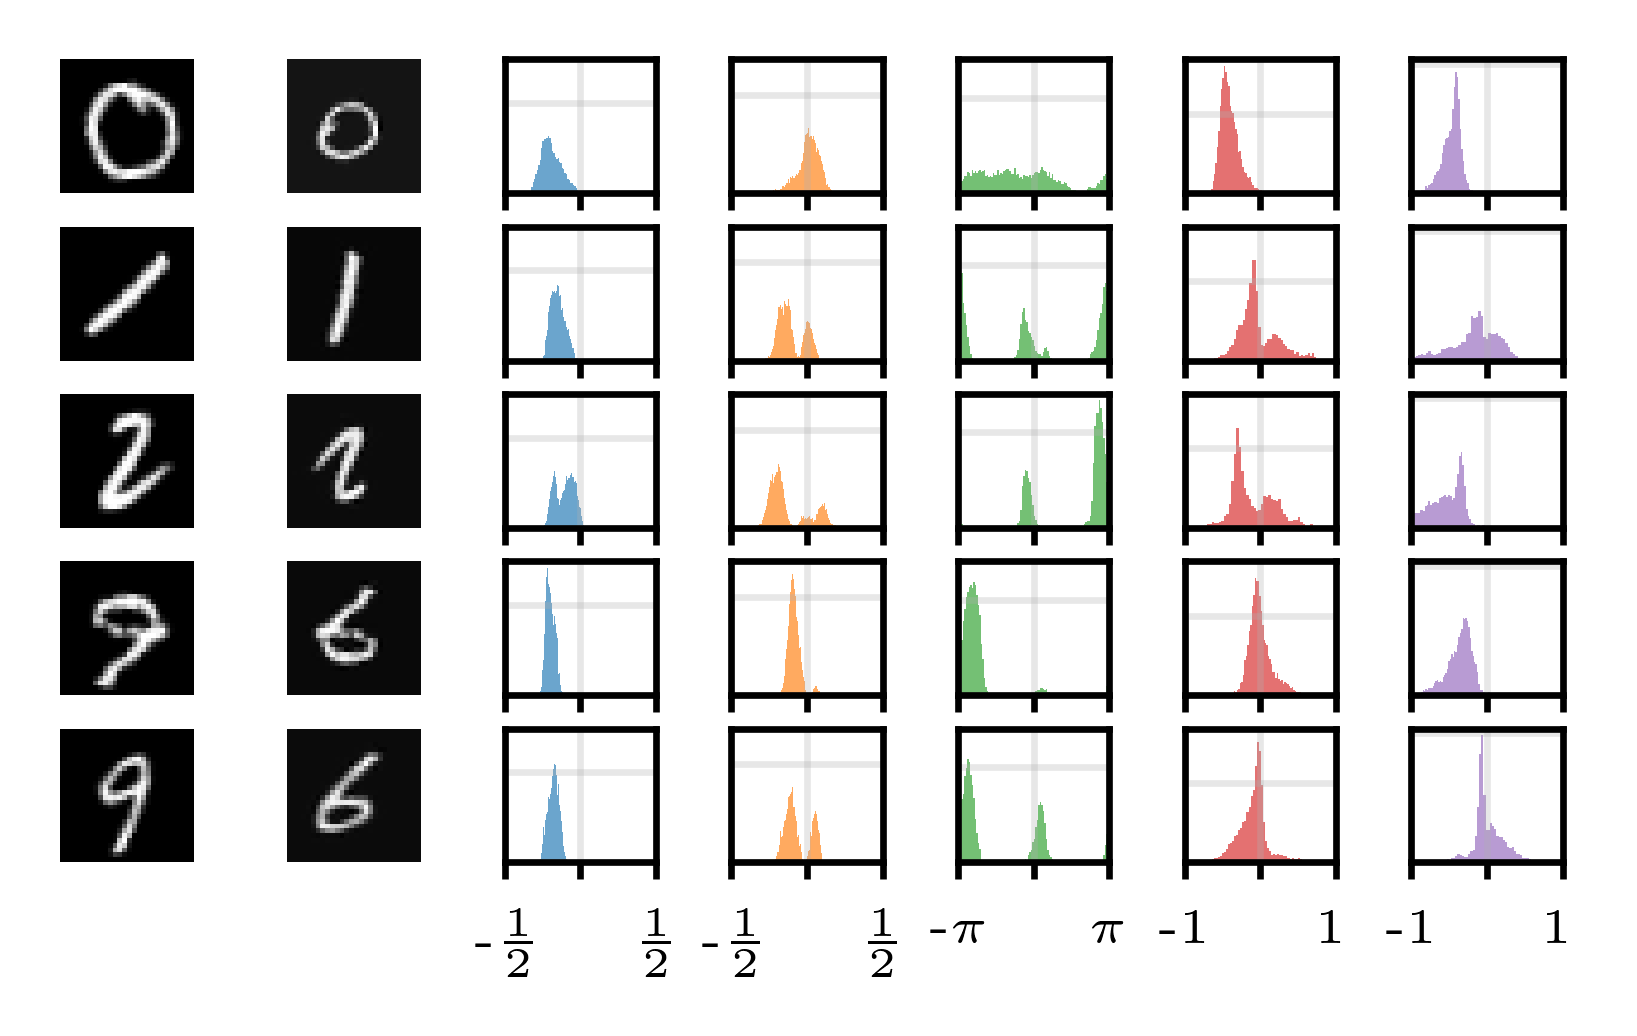

In [46]:
idxs = [
    43,
    65,
    84,
    18,
    27,
]
val_images = list(batch['image'][0].numpy()[idxs])

golden_ratio = (5**.5 - 1) / 2
fig, axs = plt.subplots(nrows=len(idxs), ncols=7, dpi=600, constrained_layout=False, sharey='col',
                           figsize=(line_width, text_width * golden_ratio * len(idxs) / 12),
                        #    gridspec_kw={"width_ratios": [1.25, 1.25, 4, 4, 4, 4, 4]}
                           ) 

for row, (image, ax) in enumerate(zip(val_images, axs)):
    proto = get_prototype(image, rng)[0]
    _, ηs, log_probs = jax.vmap(resample, in_axes=(None, 0))(image, jax.vmap(random.fold_in, in_axes=(None, 0))(rng, np.arange(10000)))


    # # filter out the samples with low probability
    ηs_ = np.array(ηs[log_probs > np.log(1e-3)])   

    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(proto, cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')

    # filter out very large and small translations / scalings
    ηs_ = ηs_[(ηs_[:, 0] > -1) & (ηs_[:, 0] < 1)]
    ηs_ = ηs_[(ηs_[:, 1] > -1) & (ηs_[:, 1] < 1)]
    ηs_ = ηs_[(ηs_[:, 3] > -2) & (ηs_[:, 3] < 2)]
    ηs_ = ηs_[(ηs_[:, 4] > -2) & (ηs_[:, 4] < 2)]

    # apply a modulus of 2pi to the rotation angle
    def wrap(x):
        return jax.lax.cond(
            (-jnp.pi <= x) & (x <= jnp.pi),
            lambda _: x,
            lambda _: ((x + jnp.pi) % (2 * jnp.pi)) - jnp.pi,
            operand=None
        )
    ηs_[:, 2] = jax.vmap(wrap)(ηs_[:, 2])

    bounds = [
        (-0.5, 0.5),
        (-0.5, 0.5),
        (-np.pi, np.pi),
        (-1., 1.),
        (-1., 1.),
    ]

    for i in range(5):
        ax[i + 2].hist(ηs_[:, i], bins=100, density=True, color=f'C{i}', alpha=0.66, log=False, edgecolor='none')
        ax[i + 2].set_xlim(bounds[i])
    
    ax[2].set_xticks([-.5, 0, .5])
    ax[2].set_xticklabels([r"-$\tfrac{1}{2}$", "", r"$\tfrac{1}{2}$"])
    ax[3].set_xticks([-.5, 0, .5])
    ax[3].set_xticklabels([r"-$\tfrac{1}{2}$", "", r"$\tfrac{1}{2}$"])
    ax[4].set_xticks([-np.pi, 0, np.pi])
    ax[4].set_xticklabels([r"-$\pi$", "", r"$\pi$"])
    ax[5].set_xticks([-1, 0, 1])
    ax[5].set_xticklabels([r"-1", "", r"1"])
    ax[6].set_xticks([-1, 0, 1])
    ax[6].set_xticklabels([r"-1", "", r"1"])

    # if row == 0:
    #     # add titles to the subplots
    #     ax[0].set_title("$\mathbf{x}$")
    #     ax[1].set_title("$\hat\mathbf{x}$")
    #     ax[2].set_title(r"$T_x$")
    #     ax[3].set_title(r"$T_y$")
    #     ax[4].set_title(r"$R$")
    #     ax[5].set_title(r"$S_x$")
    #     ax[6].set_title(r"$S_y$")

    if row != len(idxs) - 1:
        # remove the ticks labels
        for i in range(7):
            ax[i].set_xticklabels([])


            
    
    for i in range(7):
        ax[i].set_yticklabels([])
        # also remove the tick markers, but keep the ticks themselves
        ax[i].tick_params(axis='y', which='both', length=0)
        ax[i].tick_params(axis='x', which='major', length=2)
    
        # set font size for the tick labels
        # ax[i].tick_params(axis='x', which='major', labelsize=5)

plt.subplots_adjust(wspace=0.5, hspace=0.25)
plt.margins(0.)

plt.savefig('mnist_dists_single.pdf', pad_inches=0.0, bbox_inches='tight', dpi=600)   
# plt.show()